# Twitter Spam Classifier

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn import cross_validation, grid_search, metrics, neighbors, tree, naive_bayes, ensemble, svm, calibration, feature_selection, pipeline ,preprocessing

pd.set_option("display.max_columns",25)

## Dataset - Social honeypot icwsm 2011

In [ ]:
#!curl -O 'http://infolab.tamu.edu/static/users/kyumin/social_honeypot_icwsm_2011.zip'&& unzip social_honeypot_icwsm_2011.zip

In [8]:
#Спамеры
content_polluters = pd.read_table('./content_polluters.txt', header=None, names = [
    "UserID",
    "ProfileCreatedAt",
    "ProfileCollectedAt",
    "NumberOfFollowings",
    "NumberOfFollowers",
    "NumberOfTweets",
    "LengthOfScreenName",
    "LengthOfDescriptionInUserProfile"])
content_polluters_tweets = pd.read_table('./content_polluters_tweets.txt', header=None, names = [
    "UserID",
    "TweetID",
    "Tweet",
    "TweetCreatedAt"
])

In [9]:
# Пользователь 1:1 Твит (последний по дате публикации)
content_polluters = content_polluters.set_index("UserID")
content_polluters_tweets_distinct = content_polluters_tweets.sort_values('TweetCreatedAt', ascending = False).groupby(['UserID']).first()

In [10]:
#Легитимные пользователи
legitimate_users = pd.read_table('./legitimate_users.txt', header=None, names = [
    "UserID",
    "ProfileCreatedAt",
    "ProfileCollectedAt",
    "NumberOfFollowings",
    "NumberOfFollowers",
    "NumberOfTweets",
    "LengthOfScreenName",
    "LengthOfDescriptionInUserProfile"])
legitimate_users_tweets = pd.read_table('./legitimate_users_tweets.txt', header=None, names = [
    "UserID",
    "TweetID",
    "Tweet",
    "TweetCreatedAt"
])

In [11]:
# Пользователь 1:1 Твит (последний по дате публикации)
legitimate_users = legitimate_users.set_index("UserID")
legitimate_users_tweets_distinct = legitimate_users_tweets.sort_values('TweetCreatedAt', ascending = False).groupby(['UserID']).first()

In [13]:
# List of spamwords
with open("blacklist.txt", "r", encoding='utf-8') as f:
    spamwords=f.read().splitlines()

In [190]:
spammers = pd.concat([content_polluters, content_polluters_tweets_distinct], axis=1, join='inner')
spammers['IsSpammer'] = 1

nonspammers =  pd.concat([legitimate_users, legitimate_users_tweets_distinct], axis=1, join='inner')
nonspammers['IsSpammer'] = 0

data = pd.concat([spammers, nonspammers])

## Additional features extraction

In [191]:
#User features
data["ProfileCreatedAt"] = pd.to_datetime(data["ProfileCreatedAt"])
data["ProfileCollectedAt"] = pd.to_datetime(data["ProfileCollectedAt"])
data["AccountAge"] = (data["ProfileCollectedAt"] - data["ProfileCreatedAt"]).astype('timedelta64[h]')

data["Flwrs/Flwngs"] = data["NumberOfFollowers"].divide(data["NumberOfFollowings"], fill_value=True)
data.replace(np.inf, data["NumberOfFollowers"], inplace = True)

data["Reputation"] = data["NumberOfFollowers"].divide((data["NumberOfFollowers"] + data["NumberOfFollowings"]), fill_value=True)
data.replace(np.inf, data["NumberOfFollowers"], inplace = True)

data["FlwngsIncrease"] = data["NumberOfFollowings"].divide(data["AccountAge"])
data.replace(np.inf, data["NumberOfFollowings"], inplace = True)

data["TweetsPerDay"]  = data["NumberOfTweets"].divide((data["AccountAge"] / 24), fill_value=True)
data.replace(np.inf, data["NumberOfTweets"], inplace = True)

data["TweetsPerWeek"]  = data["NumberOfTweets"].divide((data["AccountAge"] / (24 * 7)), fill_value=True)
data.replace(np.inf, data["NumberOfTweets"], inplace = True)

In [223]:
data["TweetWordsList"] = data["Tweet"].str.split()
#data["CleanTweet"] = data["Tweet"].str.split()

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

In [220]:
#Content features
data["NumberOfWords"] = data["Tweet"].str.count('\w+')

data["NumberOfSymbols"] = data["Tweet"].str.len()

data["NumberOfSpaces"] = data["Tweet"].str.count(' ')

data["NumberOfCl"] = data["Tweet"].str.count('[A-Z]*')  # ???

data["ClperWord"] = data["NumberOfCl"].divide(data["NumberOfWords"]) # ???
data.replace(np.inf, data["NumberOfCl"], inplace = True)

data['MaxWord'] = -99 # ???

data['AvgWord'] = -99 # ???

data["NumberOfEm"] = data["Tweet"].str.count('\!')

data["NumberOfQm"] = data["Tweet"].str.count('\?')

data["NumberOfURLs"] = data["Tweet"].str.count('(https://\S+|http://\S+)')

data["URLperWord"] = data["NumberOfURLs"].divide(data["NumberOfWords"])
data.replace(np.inf, data["NumberOfURLs"], inplace = True)

data["NumberOfMentions"] = data["Tweet"].str.count('(@\S+)')

data["MentionsperWord"] = data["NumberOfMentions"].divide(data["NumberOfWords"])
data.replace(np.inf, data["NumberOfMentions"], inplace = True)

data["NumberOfHashtags"] = data["Tweet"].str.count('(#\S+)')

data["HashtagsperWord"] = data["NumberOfHashtags"].divide(data["NumberOfWords"])
data.replace(np.inf, data["NumberOfHashtags"], inplace = True)

data["NumberOfSpamWords"] = data["Tweet"].str.count('(' + '|'.join(set([x for x in spamwords if all(ord(c) < 128 and c.isalpha() for c in x)])) + ')')

data["SpamWordsperWord"] = data["NumberOfSpamWords"].divide(data["NumberOfWords"])
data.replace(np.inf, data["NumberOfSpamWords"], inplace = True)


#data.fillna(0, inplace = True)

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

In [199]:
data[["Tweet","NumberOfWords"]]

,Tweet,NumberOfWords
UserID,,
6301,@ntdesignsMUA Kind of like McFeast. Amazing!!!...,20
10836,#Techsailor shares: http://bit.ly/9IJ4p9 Explo...,13
10997,ugh. woke up. hoping I can drop off again.,9
633293,I remember when I didn't HAVE to work at 2am.....,14
717883,DJ Godfather - Lolli Pop (Detroit Ghetto Tech ...,24
763068,@educabo well... I've been at the office since...,15
783705,@smellycents please don't shot anyone,6
788352,@erincarrasco If anyone is listening... I need...,14
810011,Workshop #40: Statistika by Smi mc | Audiotuts...,11


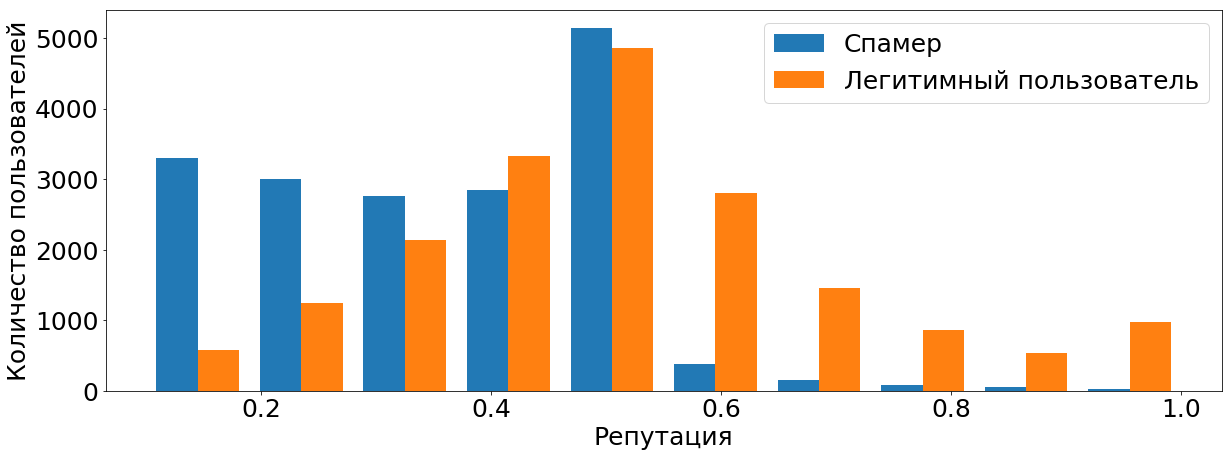

In [15]:
plt.rcParams['figure.figsize'] = (20,7)
plt.rcParams['font.size'] = 25   

data0=data[data.Reputation > .1]
plt.hist([data0[data0.IsSpammer==1].Reputation.values,
          data0[data0.IsSpammer==0].Reputation.values],label=["Спамер","Легитимный пользователь"],
          alpha = .99)
plt.legend()
plt.xlabel("Репутация")
plt.ylabel("Количество пользователей")
plt.savefig("reputation.png")
plt.show()

In [16]:
feature_cols = { "UserFeatures" : [
                                "LengthOfScreenName",
                                "LengthOfDescriptionInUserProfile",
                                "NumberOfFollowings",
                                "NumberOfFollowers",
                                "NumberOfTweets",
                                "AccountAge",
                                "Flwrs/Flwngs",
                                "FlwngsIncrease",
                                "TweetsPerDay",
                                "TweetsPerWeek"
                                ],
               "ContentFeatures":[ 
                                  "NumberOfWords",
                                  "NumberOfSymbols",
                                  "NumberOfSpaces",
                                  "NumberOfEm",
                                  "NumberOfQm",
                                  "NumberOfURLs",
                                  "NumberOfHashtags",
                                  "NumberOfMentions",
                                  "NumberOfSpamWords"
                                ],
 
               }
X = data[feature_cols["UserFeatures"] + feature_cols["ContentFeatures"]]
Y = data['IsSpammer']

#X = (X - ((X.max() - X.min()) / 2)) / ((X.max() - X.min())/2)
#X = (X - X.mean())/ ((X.max() - X.min())/2)
#№X.max()

In [18]:
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, train_size=0.4, random_state = 0)

In [19]:
def print_report(RealValues, PredictedValues ):
    print('Accuracy: ' + str(metrics.accuracy_score(RealValues, PredictedValues)))
    print('\n' + 'Classification report:')
    print(metrics.classification_report(RealValues, PredictedValues))
    print('\n' + 'Confusion matrix: ')
    print(metrics.confusion_matrix(RealValues, PredictedValues))

def print_cross_validation(model, X, Y):
    scores = cross_validation.cross_val_score(model, X, Y, cv=10, scoring='accuracy')
    #print(scores)
    print('Cross Validation Score: ' + str(scores.mean()))

In [20]:
cv = cross_validation.StratifiedShuffleSplit(Y_train, n_iter = 10, test_size = 0.2, random_state = 0)

## KNN

In [21]:
knn = neighbors.KNeighborsClassifier()
#knn.get_params().keys()

In [22]:
parameters_grid = {
    'n_neighbors' : [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
    'weights' :  ['uniform', 'distance'],
}

In [23]:
grid_cv = grid_search.GridSearchCV(knn, parameters_grid, scoring = 'accuracy', cv = cv)

In [24]:
%%time
grid_cv.fit(X_train, Y_train)

Wall time: 31.4 s


GridSearchCV(cv=StratifiedShuffleSplit(labels=[1 1 ..., 0 1], n_iter=10, test_size=0.2, random_state=0),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [25]:
best_estimator = grid_cv.best_estimator_
Y_pred = best_estimator.predict(X_test)
print_report(Y_test, Y_pred)
print_cross_validation(best_estimator, X, Y)

Accuracy: 0.882655192581

Classification report:
             precision    recall  f1-score   support

          0       0.87      0.89      0.88     11575
          1       0.90      0.87      0.88     12363

avg / total       0.88      0.88      0.88     23938


Confusion matrix: 
[[10328  1247]
 [ 1562 10801]]
Cross Validation Score: 0.729896333646


In [26]:
print (grid_cv.best_score_)
print (grid_cv.best_params_)

0.8803258145363408
{'n_neighbors': 11, 'weights': 'distance'}


In [27]:
grid_cv.grid_scores_

[mean: 0.84737, std: 0.00544, params: {'n_neighbors': 1, 'weights': 'uniform'},
 mean: 0.84737, std: 0.00544, params: {'n_neighbors': 1, 'weights': 'distance'},
 mean: 0.86964, std: 0.00461, params: {'n_neighbors': 3, 'weights': 'uniform'},
 mean: 0.86886, std: 0.00389, params: {'n_neighbors': 3, 'weights': 'distance'},
 mean: 0.87675, std: 0.00590, params: {'n_neighbors': 5, 'weights': 'uniform'},
 mean: 0.87691, std: 0.00524, params: {'n_neighbors': 5, 'weights': 'distance'},
 mean: 0.87785, std: 0.00495, params: {'n_neighbors': 7, 'weights': 'uniform'},
 mean: 0.87832, std: 0.00491, params: {'n_neighbors': 7, 'weights': 'distance'},
 mean: 0.87863, std: 0.00570, params: {'n_neighbors': 9, 'weights': 'uniform'},
 mean: 0.88004, std: 0.00509, params: {'n_neighbors': 9, 'weights': 'distance'},
 mean: 0.87794, std: 0.00514, params: {'n_neighbors': 11, 'weights': 'uniform'},
 mean: 0.88033, std: 0.00537, params: {'n_neighbors': 11, 'weights': 'distance'},
 mean: 0.87607, std: 0.00452, pa

## Naive Bayes

In [28]:
bern = naive_bayes.BernoulliNB()
bern.get_params().keys()

dict_keys(['alpha', 'binarize', 'class_prior', 'fit_prior'])

In [29]:
parameters_grid = {
    'fit_prior' : [True, False],
}

In [30]:
grid_cv = grid_search.GridSearchCV(bern, parameters_grid, scoring = 'accuracy', cv = cv)

In [31]:
%%time
grid_cv.fit(X_train, Y_train)

Wall time: 615 ms


GridSearchCV(cv=StratifiedShuffleSplit(labels=[1 1 ..., 0 1], n_iter=10, test_size=0.2, random_state=0),
       error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'fit_prior': [True, False]}, pre_dispatch='2*n_jobs',
       refit=True, scoring='accuracy', verbose=0)

In [32]:
best_estimator = grid_cv.best_estimator_
Y_pred = best_estimator.predict(X_test)
print_report(Y_test, Y_pred)
print_cross_validation(best_estimator, X, Y)

Accuracy: 0.761132926727

Classification report:
             precision    recall  f1-score   support

          0       0.72      0.83      0.77     11575
          1       0.81      0.70      0.75     12363

avg / total       0.77      0.76      0.76     23938


Confusion matrix: 
[[9578 1997]
 [3721 8642]]
Cross Validation Score: 0.755640042819


In [33]:
print (grid_cv.best_score_)
print (grid_cv.best_params_)

0.7559210526315789
{'fit_prior': False}


In [34]:
grid_cv.grid_scores_

[mean: 0.75545, std: 0.00989, params: {'fit_prior': True},
 mean: 0.75592, std: 0.00899, params: {'fit_prior': False}]

## Decision Tree

In [35]:
dt = tree.DecisionTreeClassifier()
dt.get_params().keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [37]:
parameters_grid = {
    'criterion'  : ['gini', 'entropy'],
    'splitter' : ['best','random'],
    'max_depth' : [1, 2, 3, None]
}

In [38]:
grid_cv = grid_search.GridSearchCV(dt, parameters_grid, scoring = 'accuracy', cv = cv)

In [39]:
%%time
grid_cv.fit(X_train, Y_train)

Wall time: 8.63 s


GridSearchCV(cv=StratifiedShuffleSplit(labels=[1 1 ..., 0 1], n_iter=10, test_size=0.2, random_state=0),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [1, 2, 3, None]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [40]:
best_estimator = grid_cv.best_estimator_
Y_pred = best_estimator.predict(X_test)
print_report(Y_test, Y_pred)
print_cross_validation(best_estimator, X, Y)

Accuracy: 0.884994569304

Classification report:
             precision    recall  f1-score   support

          0       0.88      0.88      0.88     11575
          1       0.89      0.89      0.89     12363

avg / total       0.88      0.88      0.88     23938


Confusion matrix: 
[[10201  1374]
 [ 1379 10984]]
Cross Validation Score: 0.841311787963


In [41]:
print (grid_cv.best_score_)
print (grid_cv.best_params_)

0.8817042606516291
{'criterion': 'entropy', 'max_depth': None, 'splitter': 'best'}


In [42]:
grid_cv.grid_scores_

[mean: 0.84170, std: 0.00672, params: {'criterion': 'gini', 'max_depth': 1, 'splitter': 'best'},
 mean: 0.53982, std: 0.03347, params: {'criterion': 'gini', 'max_depth': 1, 'splitter': 'random'},
 mean: 0.84170, std: 0.00672, params: {'criterion': 'gini', 'max_depth': 2, 'splitter': 'best'},
 mean: 0.60655, std: 0.02840, params: {'criterion': 'gini', 'max_depth': 2, 'splitter': 'random'},
 mean: 0.87099, std: 0.00607, params: {'criterion': 'gini', 'max_depth': 3, 'splitter': 'best'},
 mean: 0.61147, std: 0.02576, params: {'criterion': 'gini', 'max_depth': 3, 'splitter': 'random'},
 mean: 0.87876, std: 0.00916, params: {'criterion': 'gini', 'max_depth': None, 'splitter': 'best'},
 mean: 0.86720, std: 0.01064, params: {'criterion': 'gini', 'max_depth': None, 'splitter': 'random'},
 mean: 0.84198, std: 0.00627, params: {'criterion': 'entropy', 'max_depth': 1, 'splitter': 'best'},
 mean: 0.57578, std: 0.02964, params: {'criterion': 'entropy', 'max_depth': 1, 'splitter': 'random'},
 mean: 0

## Random Forest

In [43]:
rfc = ensemble.RandomForestClassifier()
#rfc.get_params().keys()

In [44]:
parameters_grid = {
    'n_estimators' : list(range(1,20)),
    'criterion' : ['gini','entropy'],
    'max_depth' : [1,2,3,4,5,None],
    'bootstrap' : [True, False],
}

In [45]:
grid_cv = grid_search.GridSearchCV(rfc, parameters_grid, scoring = 'accuracy', cv = cv)

In [46]:
%%time
grid_cv.fit(X_train, Y_train)

Wall time: 11min 27s


GridSearchCV(cv=StratifiedShuffleSplit(labels=[1 1 ..., 0 1], n_iter=10, test_size=0.2, random_state=0),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5, None], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [47]:
best_estimator = grid_cv.best_estimator_
Y_pred = best_estimator.predict(X_test)
print_report(Y_test, Y_pred)
print_cross_validation(best_estimator, X, Y)

Accuracy: 0.925432366948

Classification report:
             precision    recall  f1-score   support

          0       0.94      0.91      0.92     11575
          1       0.92      0.94      0.93     12363

avg / total       0.93      0.93      0.93     23938


Confusion matrix: 
[[10516  1059]
 [  726 11637]]
Cross Validation Score: 0.888781692355


In [48]:
print (grid_cv.best_score_)
print (grid_cv.best_params_)

0.9229010025062656
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 19}


In [49]:
grid_cv.grid_scores_[-20:]

[mean: 0.91319, std: 0.00423, params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 19},
 mean: 0.87998, std: 0.00532, params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 1},
 mean: 0.87039, std: 0.00432, params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 2},
 mean: 0.90533, std: 0.00425, params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 3},
 mean: 0.90222, std: 0.00694, params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 4},
 mean: 0.91344, std: 0.00654, params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 5},
 mean: 0.91241, std: 0.00337, params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 6},
 mean: 0.91501, std: 0.00545, params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 7},
 mean: 0.91617, std: 0.005

Feature ranking:
1. feature 7 (0.270367)
2. feature 2 (0.170063)
3. feature 15 (0.077128)
4. feature 6 (0.073277)
5. feature 4 (0.068783)
6. feature 8 (0.051180)
7. feature 3 (0.047659)
8. feature 9 (0.047519)
9. feature 5 (0.039791)
10. feature 10 (0.029710)
11. feature 11 (0.029390)
12. feature 17 (0.024537)
13. feature 12 (0.021861)
14. feature 1 (0.019561)
15. feature 0 (0.014668)
16. feature 13 (0.006355)
17. feature 14 (0.003659)
18. feature 16 (0.003413)
19. feature 18 (0.001079)


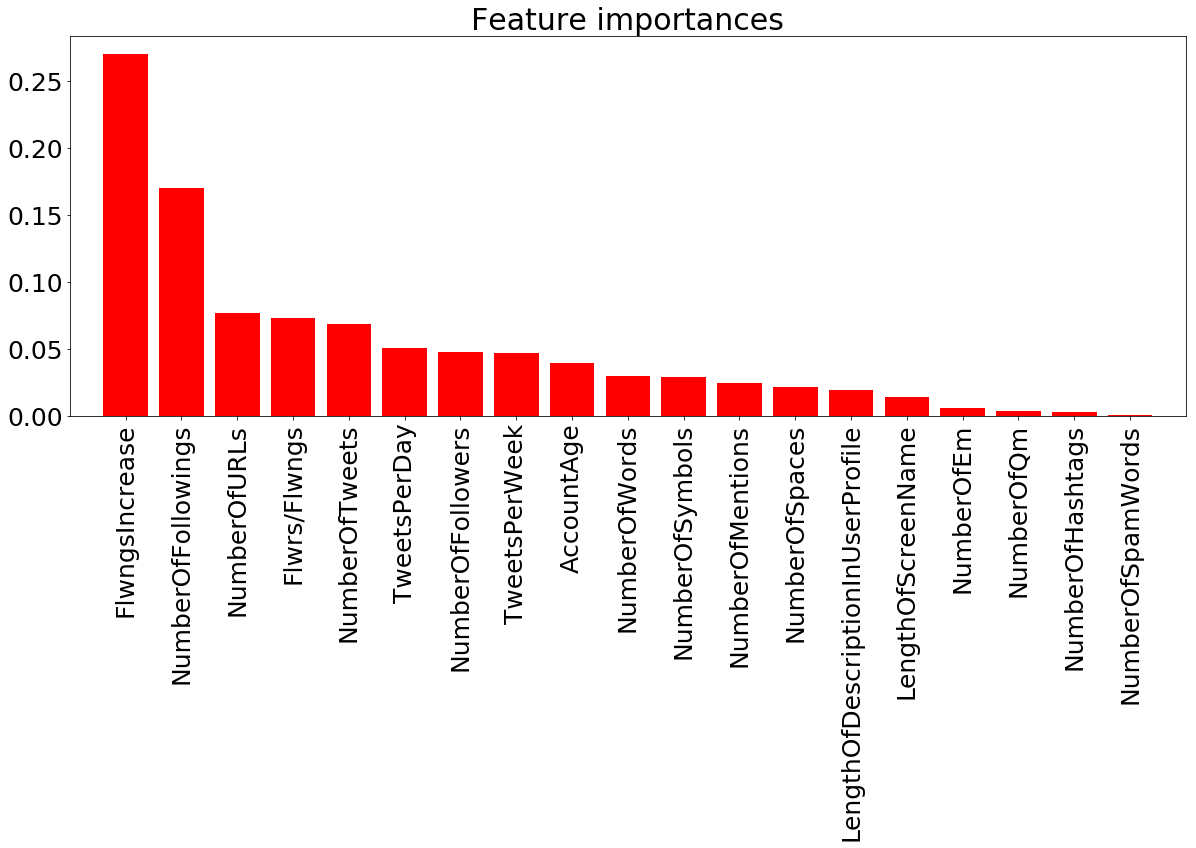

In [124]:
importances  = best_estimator.feature_importances_
std = np.std([best_estimator.feature_importances_ for tree in best_estimator.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), list(X[indices]), rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

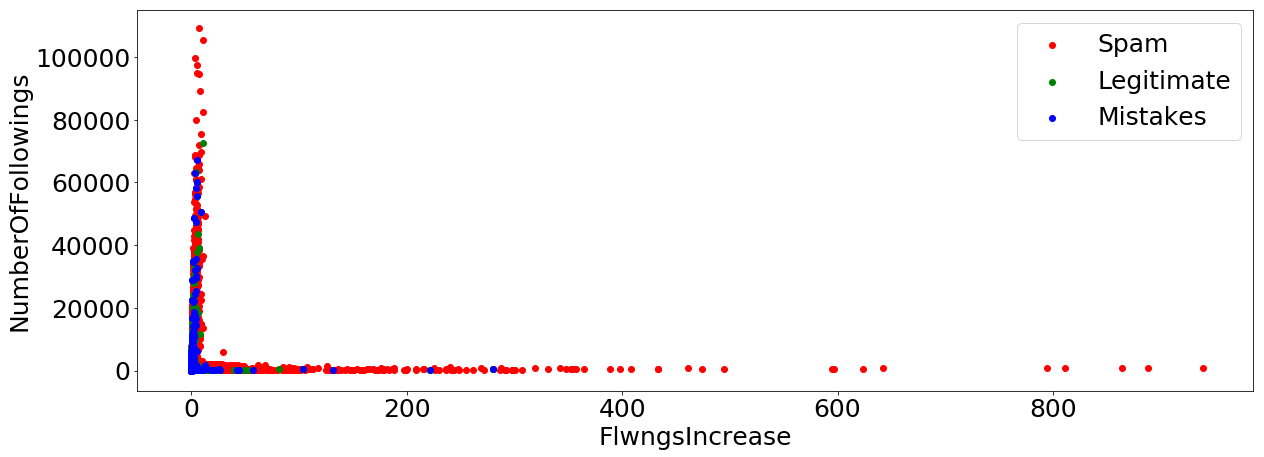

In [173]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x = data['FlwngsIncrease'].loc[data['IsSpammer'] == 1], y=data['NumberOfFollowings'].loc[data['IsSpammer'] == 1], color = 'Red', label = "Spam")
ax1.scatter(x = data['FlwngsIncrease'].loc[data['IsSpammer'] == 0], y=data['NumberOfFollowings'].loc[data['IsSpammer'] == 0], color = 'Green', label= "Legitimate")
ax1.scatter(x = data['FlwngsIncrease'].loc[Corr2.loc[Corr2['IsCorrect'] == False].index], y=data['NumberOfFollowings'].loc[Corr2.loc[Corr2['IsCorrect'] == False].index], color = 'Blue', label= "Mistakes")
plt.xlabel("FlwngsIncrease")
plt.ylabel("NumberOfFollowings")
plt.legend(loc='upper right');
plt.show()

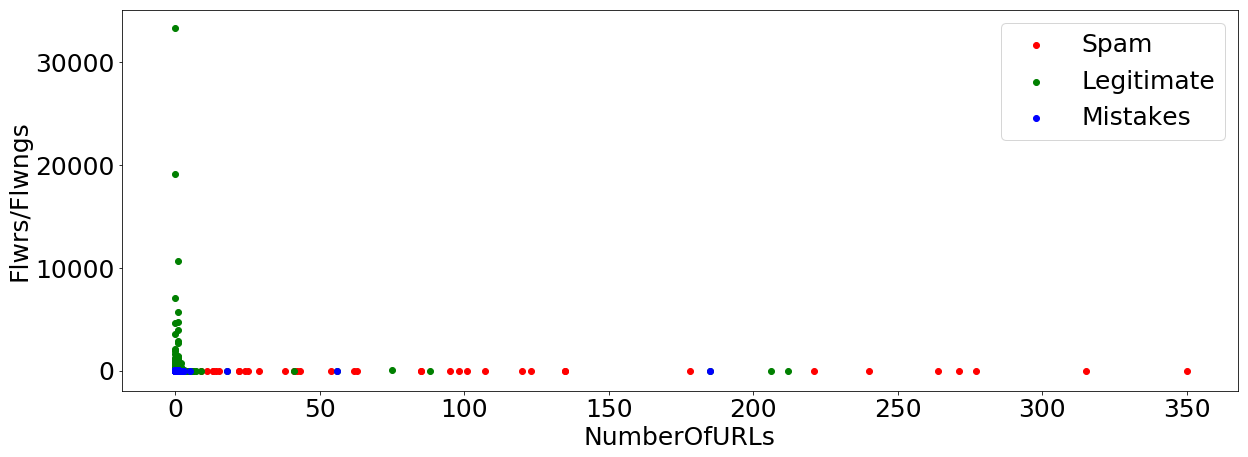

In [178]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x = data['NumberOfURLs'].loc[data['IsSpammer'] == 1], y=data['Flwrs/Flwngs'].loc[data['IsSpammer'] == 1], color = 'Red', label = "Spam")
ax1.scatter(x = data['NumberOfURLs'].loc[data['IsSpammer'] == 0], y=data['Flwrs/Flwngs'].loc[data['IsSpammer'] == 0], color = 'Green', label= "Legitimate")
ax1.scatter(x = data['NumberOfURLs'].loc[Corr2.loc[Corr2['IsCorrect'] == False].index], y=data['Flwrs/Flwngs'].loc[Corr2.loc[Corr2['IsCorrect'] == False].index], color = 'Blue', label= "Mistakes")
plt.xlabel("NumberOfURLs")
plt.ylabel("Flwrs/Flwngs")
plt.legend(loc='upper right');
plt.show()

In [169]:
#Tests = {'IsFN': Y_pred != Y_test & Y_test == 1,
#         'IsFP': Y_pred != Y_test & Y_test == 0}
Corr2 = pd.DataFrame(data=Corr)
Corr2.loc[Corr2['IsCorrect'] == False].index

Int64Index([ 68436848,  83076908,  42447746, 134588518,  58205927,  78869321,
             69435170,  99134071,  36922853, 100983447,
            ...
            108206097, 169611931,  43859782,  88047810,  58227237, 104038545,
                10997,  71329773,  57054499,  32589620],
           dtype='int64', name='UserID', length=1785)

In [183]:
data.loc[data['Flwrs/Flwngs'] > 30000]

,ProfileCreatedAt,ProfileCollectedAt,NumberOfFollowings,NumberOfFollowers,NumberOfTweets,LengthOfScreenName,LengthOfDescriptionInUserProfile,TweetID,Tweet,TweetCreatedAt,IsSpammer,Reputation,...,FlwngsIncrease,TweetsPerDay,TweetsPerWeek,NumberOfWords,NumberOfSpaces,NumberOfSymbols,NumberOfQm,NumberOfEm,NumberOfURLs,NumberOfMentions,NumberOfHashtags,NumberOfSpamWords
UserID,,,,,,,,,,,,,,,,,,,,,,,,,
19877054,2009-02-01 15:11:38,2009-11-21 12:15:14,1,33344,526,11,102,5924324822,@ my boys crib playin 2K10.he just used the ba...,2009-11-21 12:11:45,0,0.99997,...,0.000142,1.795988,12.571916,21,21,117,0,0,0,0,0,1


In [158]:
Y_test

UserID
21069781     0
102179859    1
47333321     1
118749743    1
68436848     0
36194131     0
31395163     0
64232031     0
38957358     0
80545504     0
70818027     0
161689043    1
78558198     1
76512253     1
83076908     0
26588435     1
23560091     0
42447746     0
20780650     1
30208834     0
36731667     1
14811476     0
30152138     0
66145682     0
140053814    1
84282096     0
134588518    1
16845489     0
86340431     0
25429996     1
            ..
35522273     0
78123169     0
16154421     0
44937591     0
110548420    1
57054499     0
63684858     1
139048732    1
67848158     0
83517842     0
18577266     0
79099240     1
15470773     1
32589620     0
54166222     1
82271228     1
14165753     0
102504645    1
34089169     1
56807077     0
52650761     0
40649030     1
43677238     0
61090619     0
122028557    1
124317574    1
110009410    1
47203        0
71247722     1
25163025     0
Name: IsSpammer, dtype: int64

## SVM

In [63]:
svc = svm.SVC()
svc.get_params().keys()

dict_keys(['C', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [58]:
 parameters_grid = {
     'kernel' : ['linear', 'poly', 'rbf', 'sigmoid' ],
     'reduce_dim': [feature_selection.SelectKBest(feature_selection.chi2)]
}

In [60]:
pipe = pipeline.Pipeline([
    ('classify', svc)
])
grid_cv = grid_search.GridSearchCV(pipe,svc, parameters_grid, scoring = 'accuracy', cv = cv)

TypeError: __init__() got multiple values for argument 'scoring'

In [54]:
%%time
grid_cv.fit(X_train, Y_train)

ValueError: Invalid parameter kernel for estimator LinearSVC. Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
best_estimator = grid_cv.best_estimator_
Y_pred = best_estimator.predict(X_test)
print_report(Y_test, Y_pred)
print_cross_validation(best_estimator, X, Y)

In [ ]:
print (grid_cv.best_score_)
print (grid_cv.best_params_)

In [ ]:
grid_cv.grid_scores_[:10]

## Feature extraction time

In [186]:
data = pd.concat([spammers, nonspammers])
data = data[:1000]
data.shape

(1000, 11)

In [ ]:
%%time
# LengthOfScreenName
# LengthOfDescriptionInUserProfile
# NumberofFollowings
# NumberofFollowers
# NumberofTweets
data["ProfileCreatedAt"] = pd.to_datetime(data["ProfileCreatedAt"])
data["ProfileCollectedAt"] = pd.to_datetime(data["ProfileCollectedAt"])
data["AccountAge"] = (data["ProfileCollectedAt"] - data["ProfileCreatedAt"]).astype('timedelta64[h]')
data["Flwrs/Flwngs"] = data["NumberOfFollowers"].divide(data["NumberOfFollowings"], fill_value=True)
data["Reputation"] = data["NumberOfFollowers"].divide((data["NumberOfFollowers"] + data["NumberOfFollowings"]), fill_value=True)
data["FlwngsIncrease"] = data["NumberOfFollowings"].divide(data["AccountAge"])
data["TweetsPerDay"]  = data["NumberOfTweets"].divide((data["AccountAge"] / 24), fill_value=True)
data["TweetsPerWeek"]  = data["NumberOfTweets"].divide((data["AccountAge"] / (24 * 7)), fill_value=True)

In [ ]:
%%time
data["NumberOfWords"] = data["Tweet"].str.count('\w+')
data["NumberOfSymbols"] = data["Tweet"].str.len()
data["NumberOfSpaces"] = data["Tweet"].str.count(' ')
data["NumberOfCl"] = data["Tweet"].str.count('[A-Z]*')
data["NumberOfQm"] = data["Tweet"].str.count('\?')
data["NumberOfEm"] = data["Tweet"].str.count('\!')
data["NumberOfURLs"] = data["Tweet"].str.count('(https://\S+|http://\S+)')
data["NumberOfMentions"] = data["Tweet"].str.count('(@\S+)')
data["NumberOfHashtags"] = data["Tweet"].str.count('(#\S+)')
#data["NumberOfSpamWords"] = data["Tweet"].str.count('(' + '|'.join(set([x for x in spamwords if all(ord(c) < 128 and c.isalpha() for c in x)])) + ')')

In [ ]:
'@ntdesignsMUA Kind of like McFeast. Amazing!!!! Tomato, tasty cheese, lettuce and this incredible sauce.. mmm now I am hungry again!'.count('\w+')

In [ ]:
data